# Includes

In [1]:
import os
# import sys
# import time
# import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm_notebook
from collections import defaultdict,Counter

import scipy.io
# ! pip install hiddenlayer
# import hiddenlayer as hl
# import hiddenlayer.transforms as ht
# from torch.autograd import Variable
# from pdb import set_trace


ModuleNotFoundError: No module named 'torchvision'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/huawei

/content/drive/My Drive/Colab Notebooks/huawei


In [ ]:
from blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [ ]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [ ]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [ ]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [ ]:
def eval_model(valid_queue, model,criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        out = model.forward(input_batch)


        loss=criterion(out,desired)
        draw_spectrum(input_batch,desired,out)

        
        accuracy = NMSE(input_batch, out-desired)
    return loss,accuracy

In [ ]:
def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        loss = criterion(out, desired)

        loss.backward()

        optimizer.step()


In [ ]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm_notebook(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue,net, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [ ]:
np.random.seed()
# torch.cuda.set_device()
cudnn.benchmark = True
torch.manual_seed(10)
cudnn.enabled=True
torch.cuda.manual_seed(10)

In [ ]:
Batch_size=1000

### Bahurin Data


In [ ]:
serg_data=np.load('gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [ ]:
name = 'BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [ ]:
gamma=0.95
step_size=5

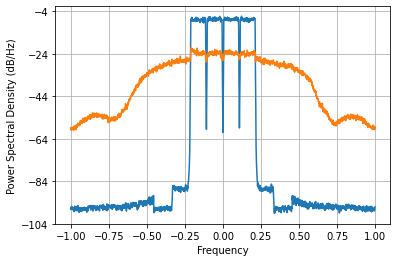

In [ ]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048)
plt.psd(d.reshape(-1,),NFFT=2048)
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [ ]:
loss_fn = nn.MSELoss()

# Model

In [ ]:
class Cell_1(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_1,self).__init__()
        self.f=AFIR(M,0)
        self.pol=Polynomial(Poly_order,Passthrough)
    def forward(self,x):
        return self.pol(self.f(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


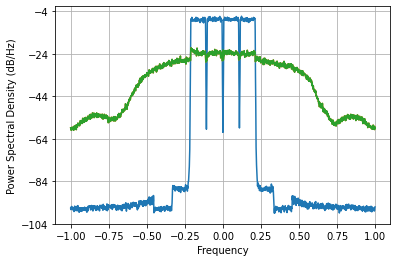

Loss =  0.001306786930903764 Accuracy =  -13.883352442156898 dbs


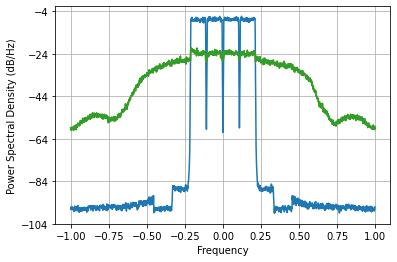

Loss =  0.0013047110227033597 Accuracy =  -13.890256951999769 dbs


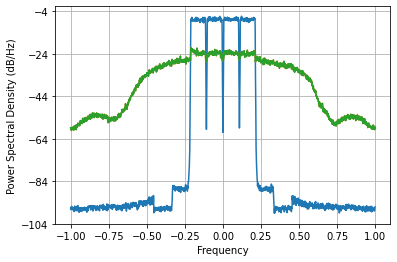

Loss =  0.0013047502889842826 Accuracy =  -13.89012624970459 dbs


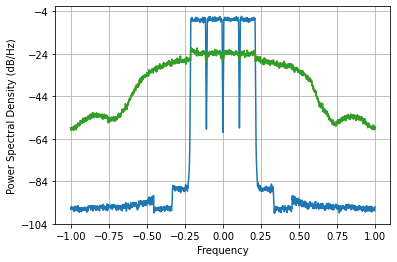

Loss =  0.001304876632131703 Accuracy =  -13.889705728814423 dbs


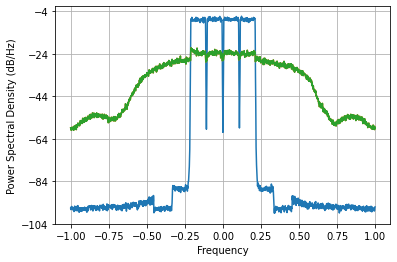

Loss =  0.001305222930296738 Accuracy =  -13.888553317732368 dbs


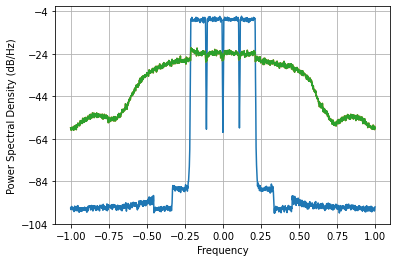

Loss =  0.0013050820030818789 Accuracy =  -13.889022258437649 dbs


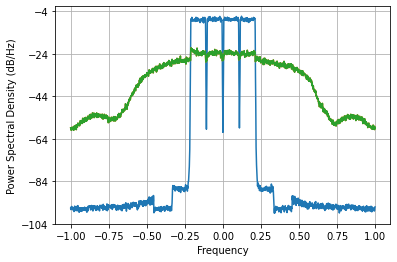

Loss =  0.0013047267399052755 Accuracy =  -13.89020463502819 dbs


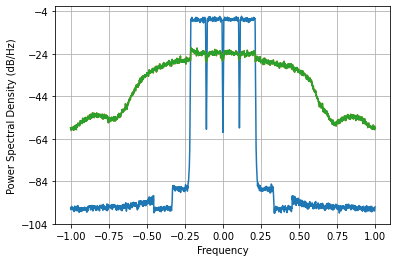

Loss =  0.0013047588025630215 Accuracy =  -13.890097911805485 dbs


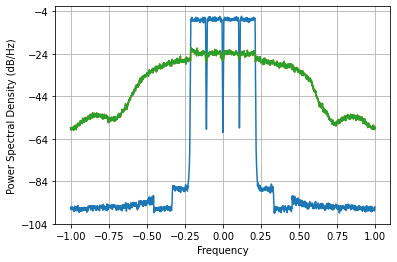

Loss =  0.001304790402712514 Accuracy =  -13.889992730646036 dbs


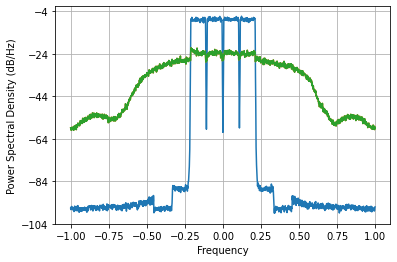

Loss =  0.001304955169336334 Accuracy =  -13.889444345880957 dbs


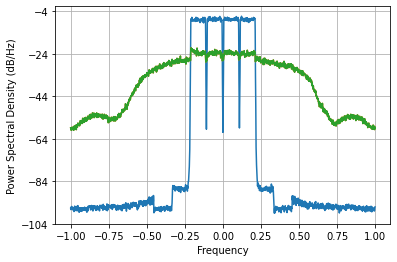

Loss =  0.001304763253127073 Accuracy =  -13.890083097940206 dbs


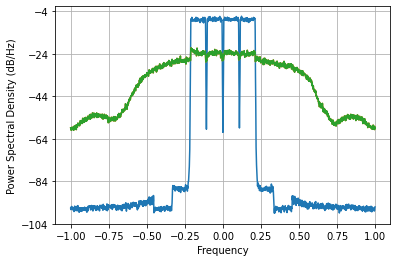

Loss =  0.0013047657306967133 Accuracy =  -13.890074851280902 dbs


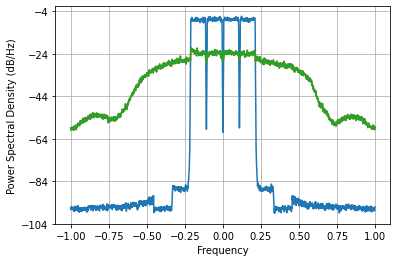

Loss =  0.0013059077677228584 Accuracy =  -13.88627521558903 dbs


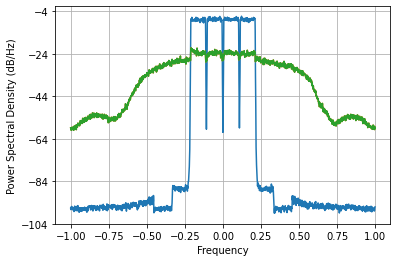

Loss =  0.0013046262686533783 Accuracy =  -13.890539078931852 dbs


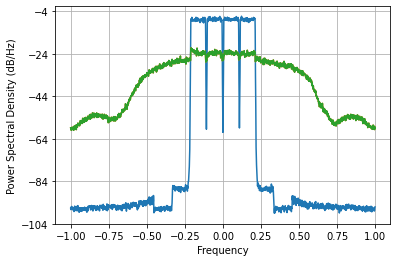

Loss =  0.0013046800806165888 Accuracy =  -13.890359949036332 dbs


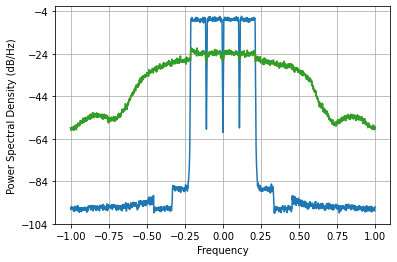

Loss =  0.0013049974856890914 Accuracy =  -13.889303517590736 dbs


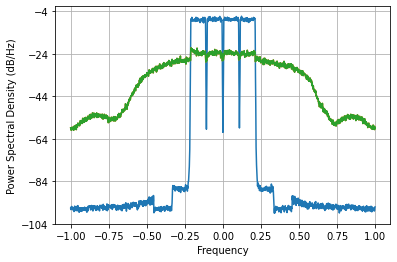

Loss =  0.0013049676651936436 Accuracy =  -13.889402759349704 dbs


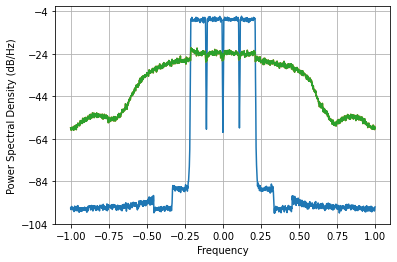

Loss =  0.001305135381637843 Accuracy =  -13.888844633290818 dbs


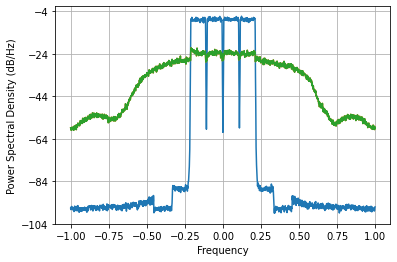

Loss =  0.0013049854584567951 Accuracy =  -13.889343543604166 dbs


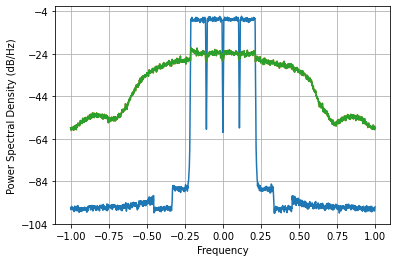

Loss =  0.0013049945444507985 Accuracy =  -13.889313305847143 dbs



In [ ]:
net=Cell_1()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
class Cell_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_2,self).__init__()
        self.f=AFIR(M,0)
        self.pol=Polynomial(Poly_order,Passthrough)
        self.prod=Prod_cmp()
    def forward(self,x):
        return self.prod(x,self.pol(self.f(x)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


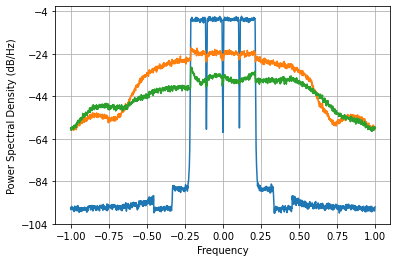

Loss =  0.0001205529324972358 Accuracy =  -24.23362247463128 dbs


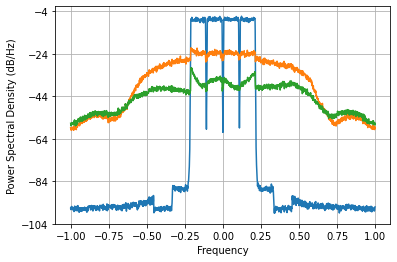

Loss =  8.490660391654189e-05 Accuracy =  -25.75598556315025 dbs


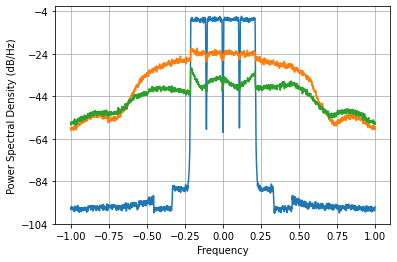

Loss =  8.385179007825344e-05 Accuracy =  -25.810276882755364 dbs


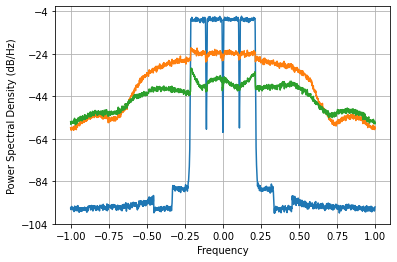

Loss =  8.337150673640984e-05 Accuracy =  -25.83522376307965 dbs


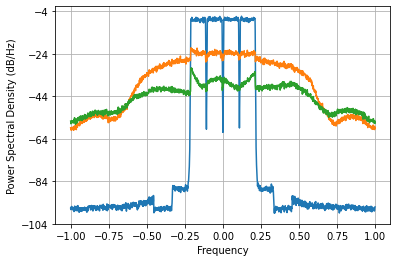

Loss =  8.341828914181491e-05 Accuracy =  -25.832787482017796 dbs


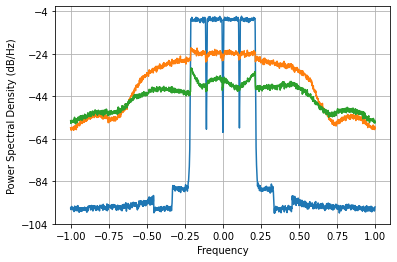

Loss =  8.32261678506349e-05 Accuracy =  -25.842801286867708 dbs


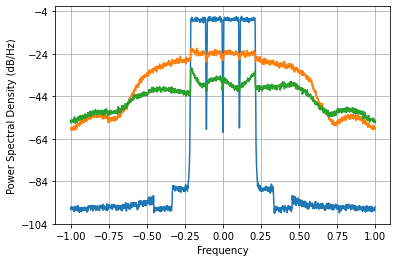

Loss =  8.362577136925378e-05 Accuracy =  -25.82199889934892 dbs


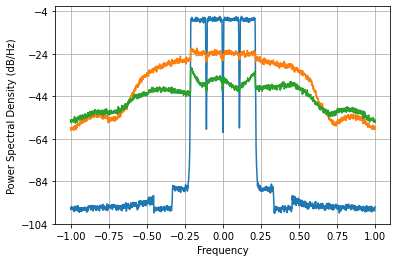

Loss =  8.401147529779723e-05 Accuracy =  -25.80201415410496 dbs


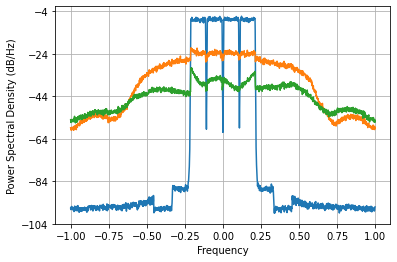

Loss =  8.425970902789066e-05 Accuracy =  -25.789200716339316 dbs


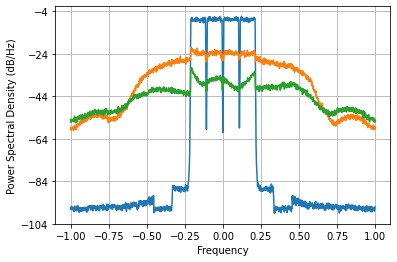

Loss =  8.432279900973463e-05 Accuracy =  -25.785950126159317 dbs


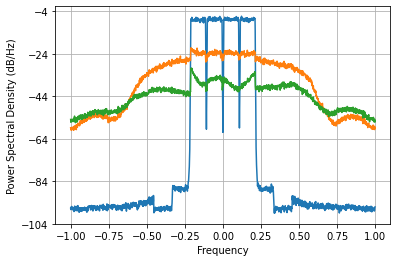

Loss =  8.383628791558395e-05 Accuracy =  -25.811079862168643 dbs


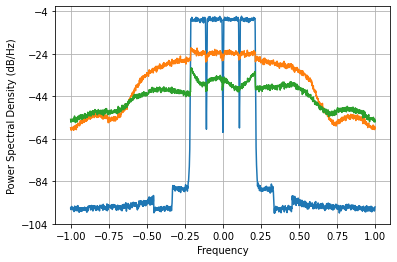

Loss =  8.385561495121174e-05 Accuracy =  -25.81007878521521 dbs


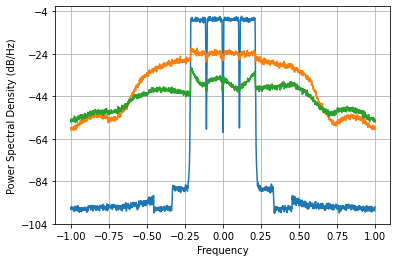

Loss =  8.369621042707234e-05 Accuracy =  -25.818342321103813 dbs


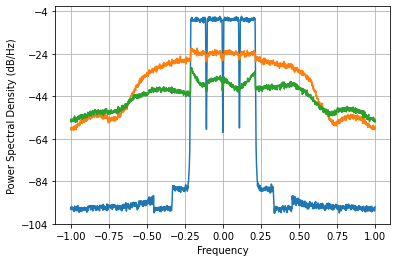

Loss =  8.34632341298491e-05 Accuracy =  -25.830448174420198 dbs


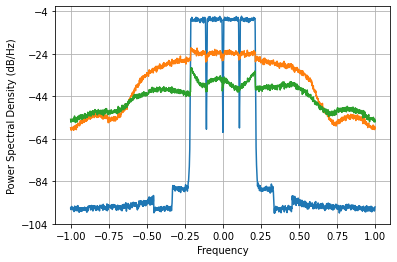

Loss =  8.328368299009004e-05 Accuracy =  -25.839801042911148 dbs


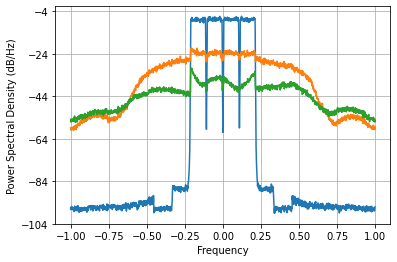

Loss =  8.334679756667847e-05 Accuracy =  -25.836511090969665 dbs


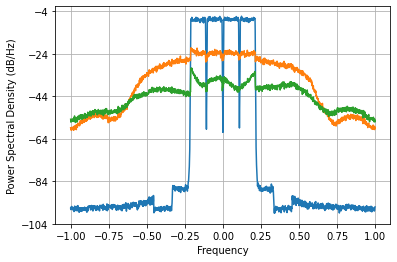

Loss =  8.312637613387558e-05 Accuracy =  -25.848011786940475 dbs


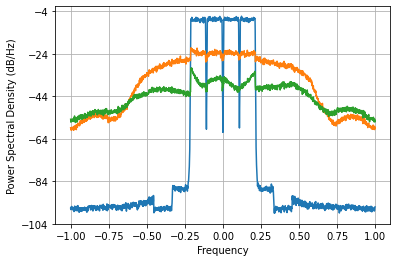

Loss =  8.29957826786474e-05 Accuracy =  -25.854840018534286 dbs


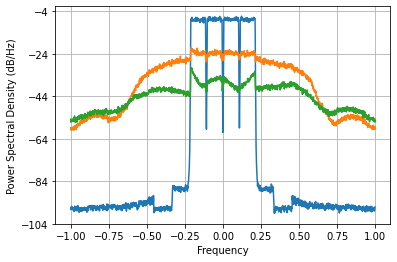

Loss =  8.294581417197379e-05 Accuracy =  -25.85745552275807 dbs


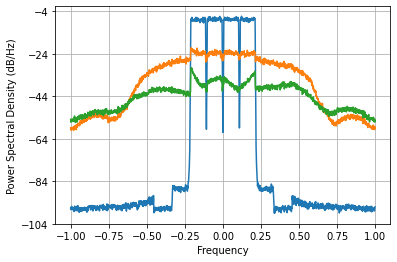

Loss =  8.292819114426374e-05 Accuracy =  -25.858378341701652 dbs



In [ ]:
net=Cell_2()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
class Cell(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell,self).__init__()
        self.f1=AFIR(M,0)
        self.f2=AFIR(M,0)
        self.delay=Delay(D)
        self.pol=Polynomial(Poly_order,Passthrough)
        self.prod=Prod_cmp()
    def forward(self,x):
        x=self.delay(x)
        up=self.f1(x) 
        return self.prod(up,self.f2(self.pol(x)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


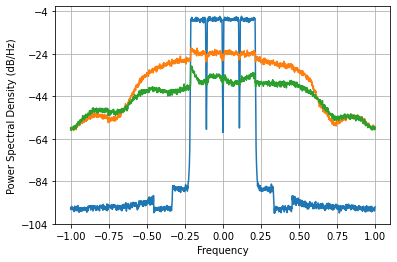

Loss =  0.00010570741737580317 Accuracy =  -24.804345643348263 dbs


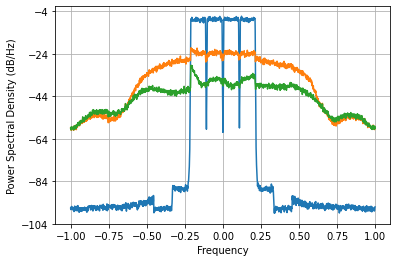

Loss =  8.939925629441472e-05 Accuracy =  -25.53206120739916 dbs


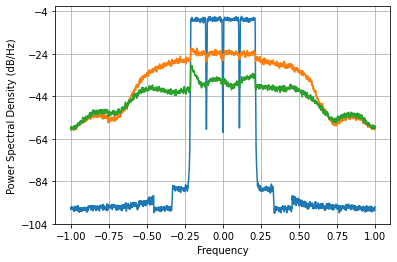

Loss =  8.617341793413435e-05 Accuracy =  -25.691667077882038 dbs


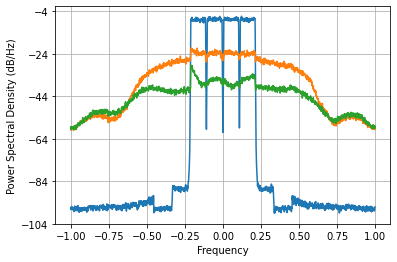

Loss =  8.495821203215236e-05 Accuracy =  -25.75334662695908 dbs


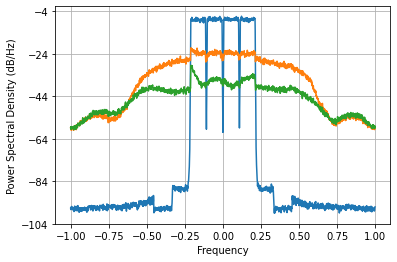

Loss =  8.435028768742856e-05 Accuracy =  -25.78453458543771 dbs


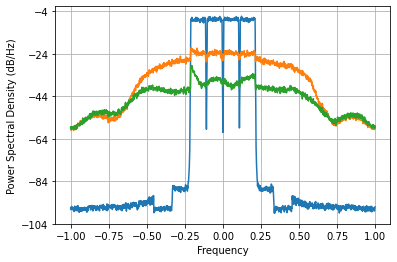

Loss =  8.360528439476513e-05 Accuracy =  -25.82306298161225 dbs


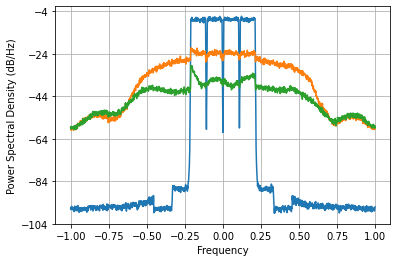

Loss =  8.336209584426348e-05 Accuracy =  -25.83571401800967 dbs


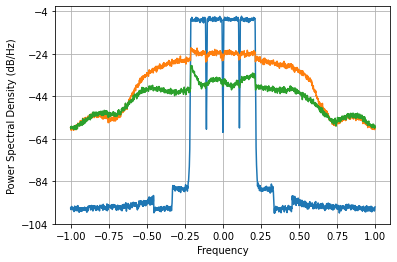

Loss =  8.299519293080215e-05 Accuracy =  -25.854870878553506 dbs


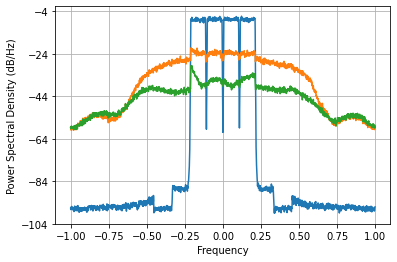

Loss =  8.254922642586262e-05 Accuracy =  -25.878270188720194 dbs


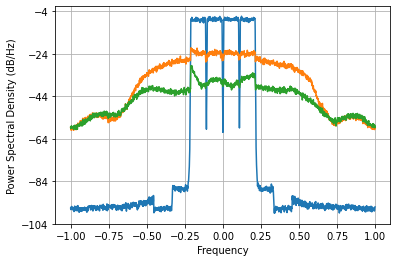

Loss =  8.209278096197183e-05 Accuracy =  -25.902350586823953 dbs


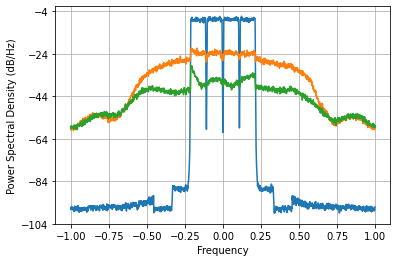

Loss =  8.156078513170322e-05 Accuracy =  -25.930586288964403 dbs


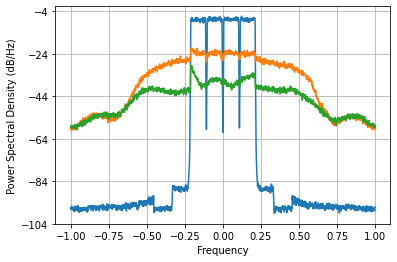

Loss =  8.121961320847804e-05 Accuracy =  -25.948791097664703 dbs


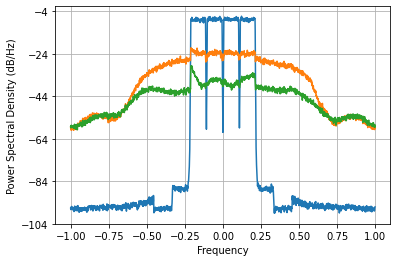

Loss =  8.087229648021556e-05 Accuracy =  -25.96740251012703 dbs


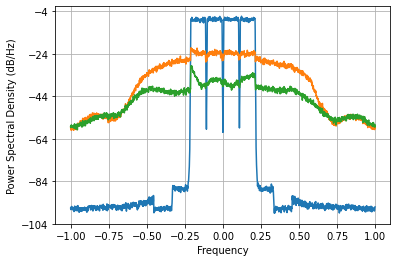

Loss =  8.05289660609444e-05 Accuracy =  -25.985879036160384 dbs


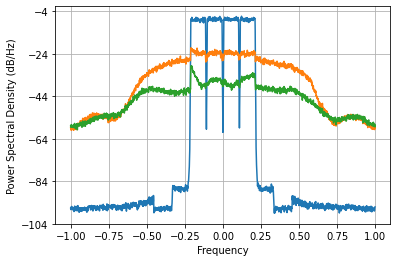

Loss =  8.019634732567609e-05 Accuracy =  -26.003854386089177 dbs


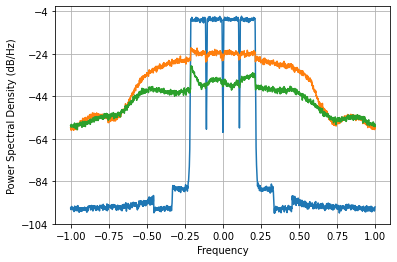

Loss =  7.992373165331565e-05 Accuracy =  -26.018642737099384 dbs


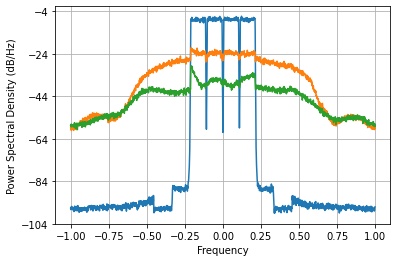

Loss =  7.971075772973636e-05 Accuracy =  -26.030230891392865 dbs


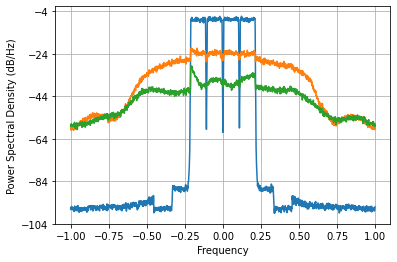

Loss =  7.950933270195568e-05 Accuracy =  -26.04121918118871 dbs


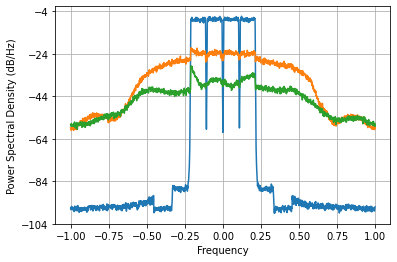

Loss =  7.932838699199032e-05 Accuracy =  -26.05111402952918 dbs


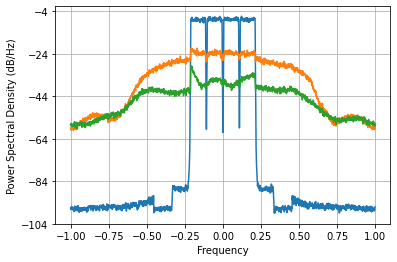

Loss =  7.916965644631591e-05 Accuracy =  -26.059812663486618 dbs



In [ ]:
net=Cell()
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

In [ ]:
class layer(nn.Module):
    def __init__(self, delay, width):
        super(layer, self).__init__()
        self.Cells = nn.ModuleList()
        for i in range(width):
#             print(i)
            self.Cells.append(Cell(D=delay[i]))

    def forward(self, x):
        out = torch.zeros_like(x)
        for i in range(len(self.Cells)):
            out += self.Cells[i](x)
        return out

In [ ]:
net=layer([0,1,2],3)
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
class LowModel(nn.Module):
    def __init__(self, layers, width, delay):
        super(LowModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out)
        return out

In [ ]:
model = LowModel(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
class Model(nn.Module):
    def __init__(self, layers, width, delay):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


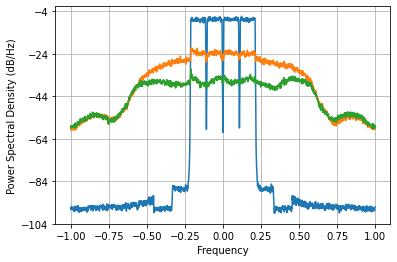

Loss =  0.00011470612400681669 Accuracy =  -24.44953421765437 dbs


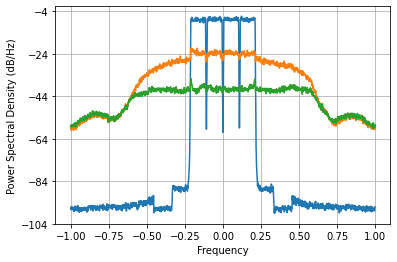

Loss =  5.243319369761379e-05 Accuracy =  -27.84933715360006 dbs


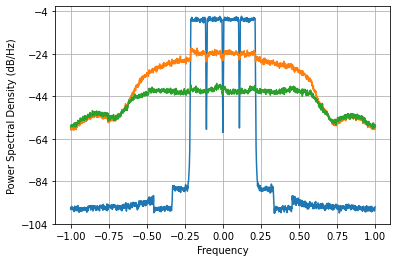

Loss =  4.3944990308389944e-05 Accuracy =  -28.616306536591157 dbs


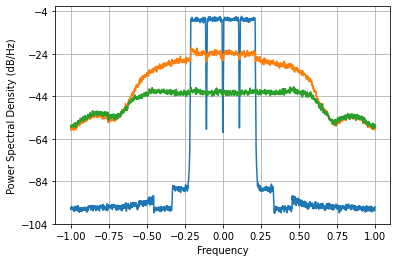

Loss =  3.7968484229140976e-05 Accuracy =  -29.25116767026969 dbs


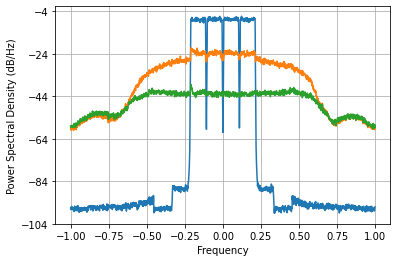

Loss =  3.438194207014396e-05 Accuracy =  -29.68209622442906 dbs


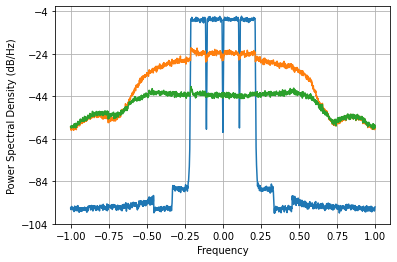

Loss =  3.1372440799964005e-05 Accuracy =  -30.07991718232144 dbs


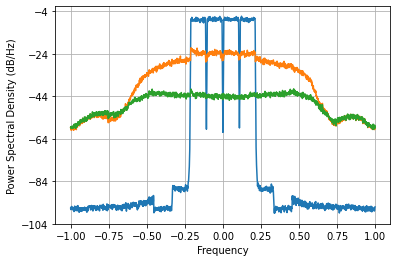

Loss =  2.879664060974622e-05 Accuracy =  -30.45198200378561 dbs


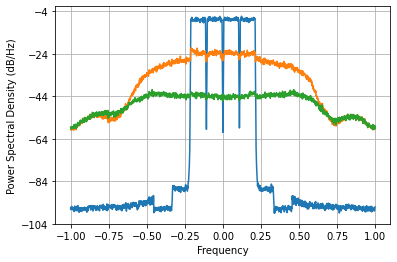

Loss =  2.7502081949218145e-05 Accuracy =  -30.651744548640703 dbs


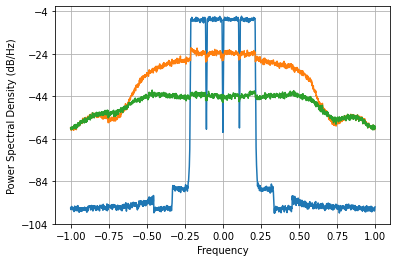

Loss =  2.6763771889872587e-05 Accuracy =  -30.769927069974976 dbs


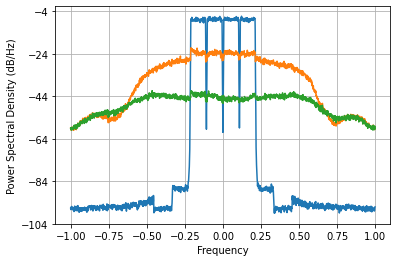

Loss =  2.4401758436008593e-05 Accuracy =  -31.171189031553013 dbs


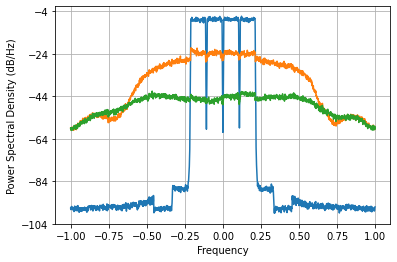

Loss =  2.297827607854729e-05 Accuracy =  -31.43222583609175 dbs


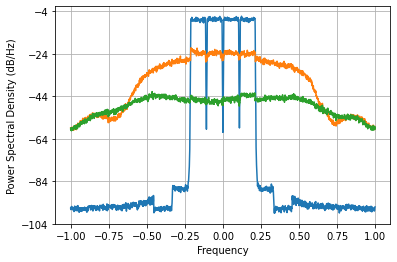

Loss =  2.1037686187241917e-05 Accuracy =  -31.81542054104405 dbs


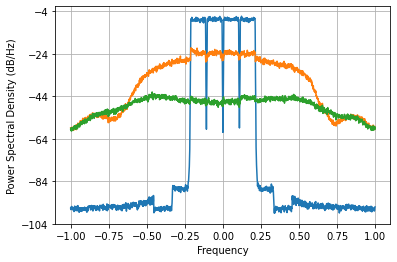

Loss =  1.9248025325918753e-05 Accuracy =  -32.20153845261692 dbs


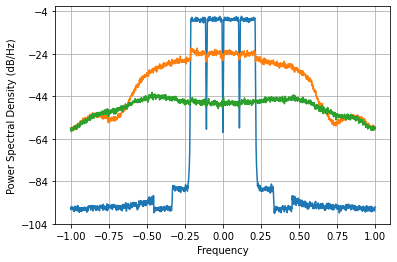

Loss =  1.7585246682215597e-05 Accuracy =  -32.593915617990724 dbs


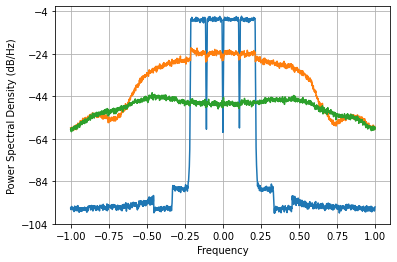

Loss =  1.6784663233080862e-05 Accuracy =  -32.79627394686682 dbs


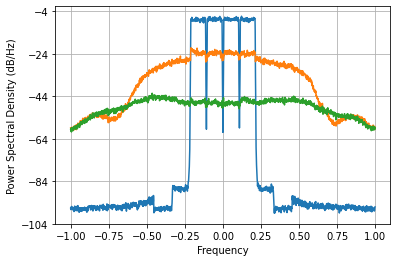

Loss =  1.6827091428740633e-05 Accuracy =  -32.78530972246114 dbs


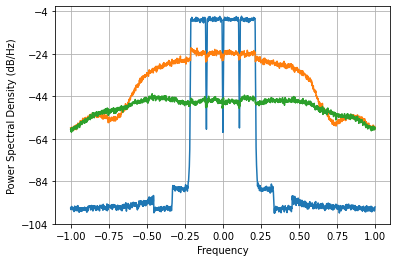

Loss =  1.730045181911415e-05 Accuracy =  -32.66482581363729 dbs


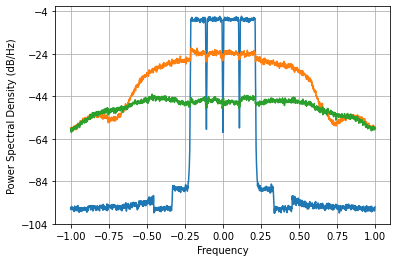

Loss =  1.69249168241139e-05 Accuracy =  -32.76013483624532 dbs


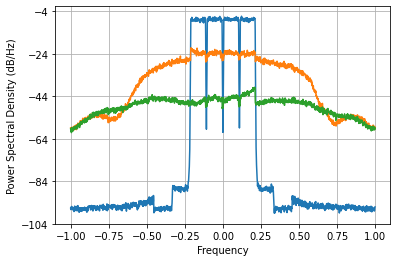

Loss =  1.8794899127217158e-05 Accuracy =  -32.30500027503555 dbs


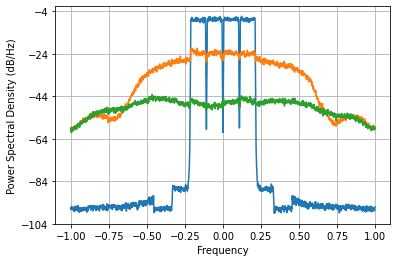

Loss =  1.5332903181449075e-05 Accuracy =  -33.189156333269835 dbs


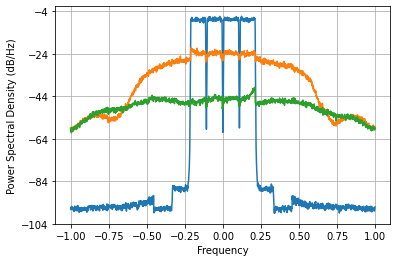

Loss =  1.7521707431930653e-05 Accuracy =  -32.609636022457394 dbs


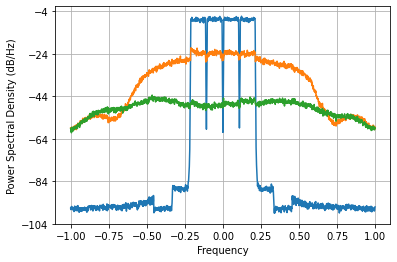

Loss =  1.4380759283180296e-05 Accuracy =  -33.467582099188384 dbs


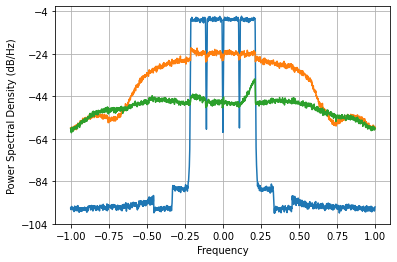

Loss =  1.849189714513535e-05 Accuracy =  -32.37558557530258 dbs


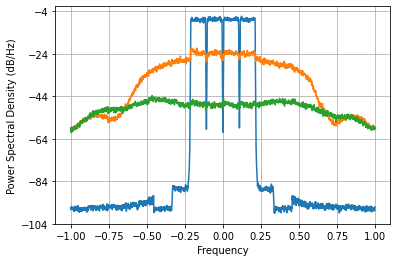

Loss =  1.366764546804921e-05 Accuracy =  -33.6884632179906 dbs


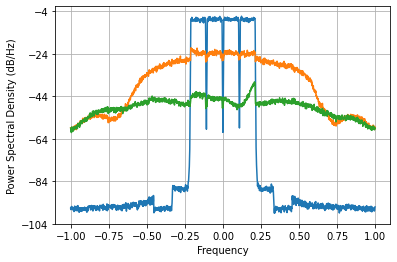

Loss =  1.8128802576842238e-05 Accuracy =  -32.46170907173195 dbs


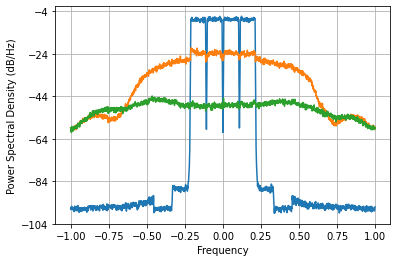

Loss =  1.3074089833841457e-05 Accuracy =  -33.88128561951896 dbs


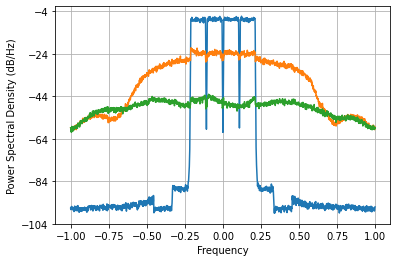

Loss =  1.4531797176802004e-05 Accuracy =  -33.42220698990154 dbs


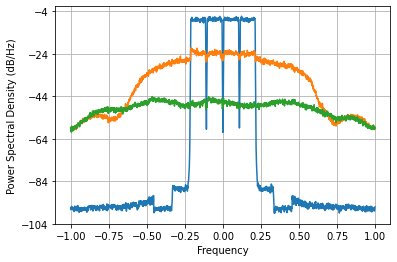

Loss =  1.3516120293696161e-05 Accuracy =  -33.7368797834004 dbs


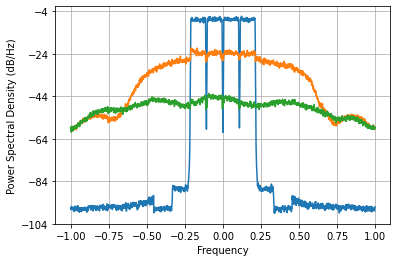

Loss =  1.4882572993088841e-05 Accuracy =  -33.31862005417882 dbs


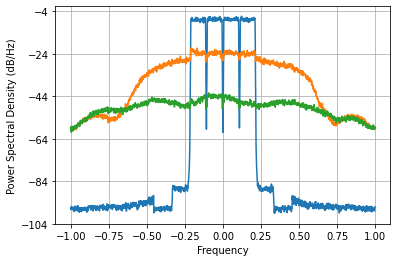

Loss =  1.518675898391081e-05 Accuracy =  -33.230749260042685 dbs


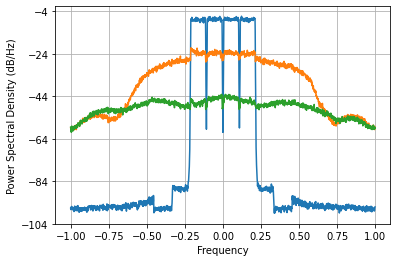

Loss =  1.457017008548378e-05 Accuracy =  -33.41075405134037 dbs


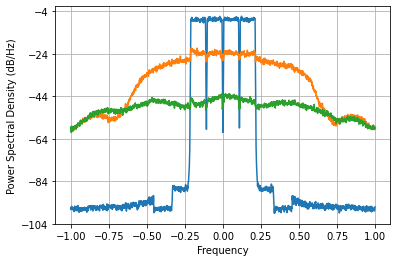

Loss =  1.4507881123008193e-05 Accuracy =  -33.42936038356698 dbs


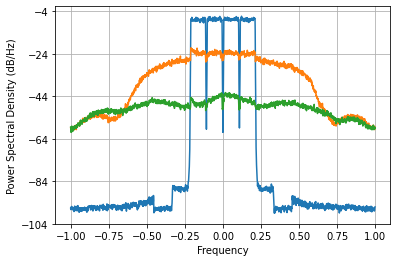

Loss =  1.4514188150733468e-05 Accuracy =  -33.42747278047736 dbs


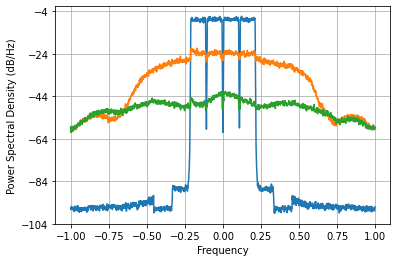

Loss =  1.4544582392313691e-05 Accuracy =  -33.418387704979 dbs


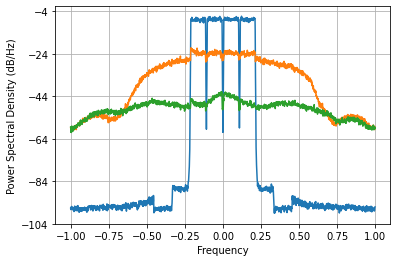

Loss =  1.3806969915939271e-05 Accuracy =  -33.64441648122354 dbs


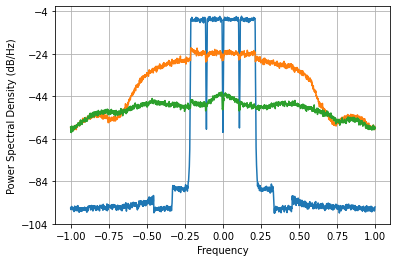

Loss =  1.3099835008428918e-05 Accuracy =  -33.872742009088164 dbs


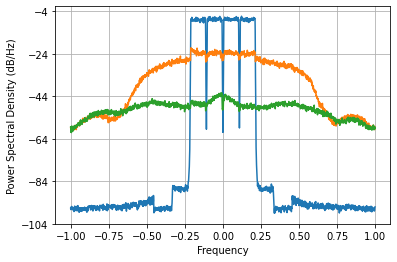

Loss =  1.2402260065478004e-05 Accuracy =  -34.110391927737524 dbs


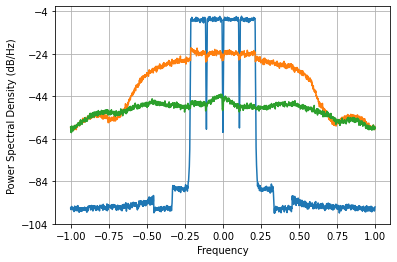

Loss =  1.1812711300206899e-05 Accuracy =  -34.32190436646629 dbs


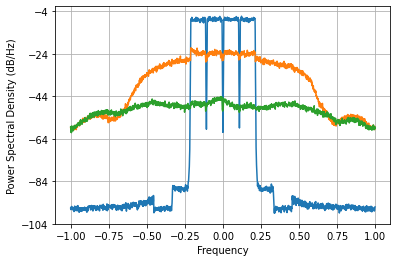

Loss =  1.1147716523162836e-05 Accuracy =  -34.573541102414644 dbs


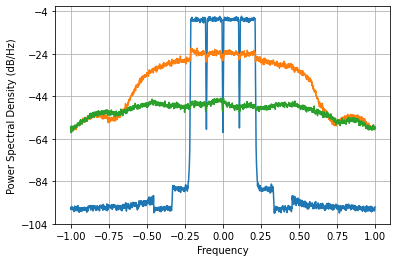

Loss =  1.0782075573503318e-05 Accuracy =  -34.7183765513696 dbs


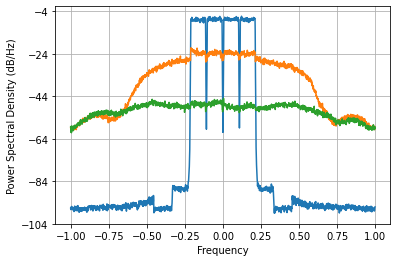

Loss =  1.0376855146353406e-05 Accuracy =  -34.88474272359384 dbs


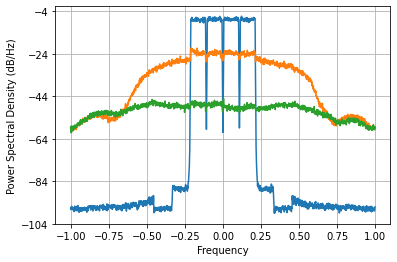

Loss =  1.006067975302221e-05 Accuracy =  -35.019127017324124 dbs


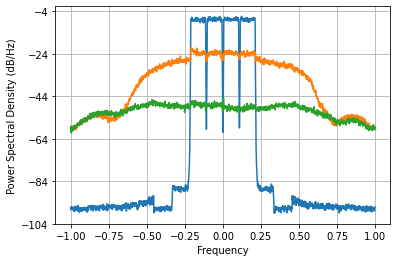

Loss =  9.833445328887135e-06 Accuracy =  -35.11834319113732 dbs


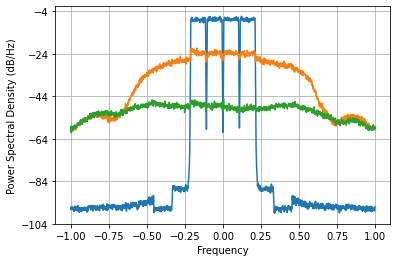

Loss =  9.69433427368565e-06 Accuracy =  -35.18022035985401 dbs


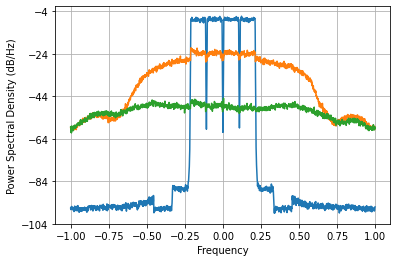

Loss =  9.70836801802111e-06 Accuracy =  -35.17393795784989 dbs


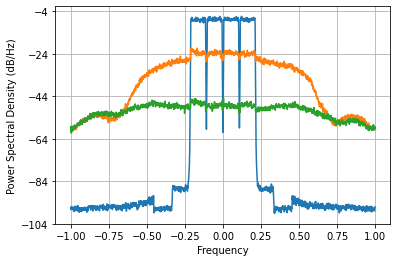

Loss =  1.0017908197545239e-05 Accuracy =  -35.03762979119348 dbs


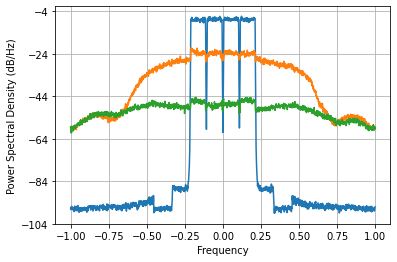

Loss =  1.0715666540781578e-05 Accuracy =  -34.74520836286571 dbs


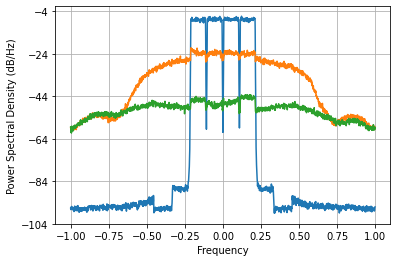

Loss =  1.1568781644688905e-05 Accuracy =  -34.41252402641393 dbs


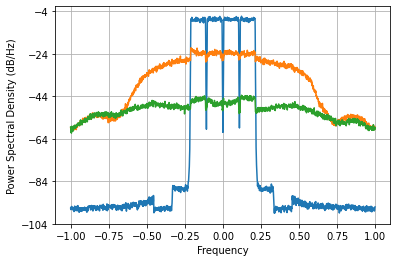

Loss =  1.1568341157534833e-05 Accuracy =  -34.41268938936076 dbs


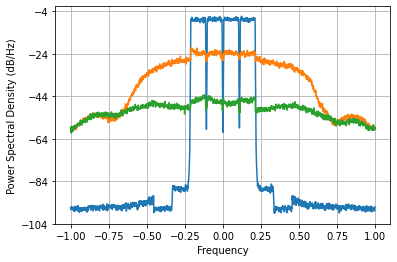

Loss =  1.135541896344677e-05 Accuracy =  -34.49336864340638 dbs


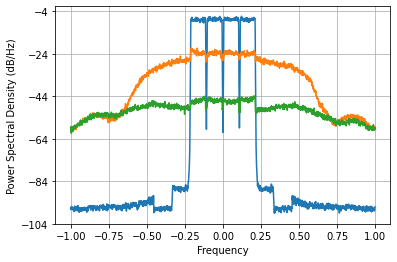

Loss =  1.143326491070588e-05 Accuracy =  -34.4636976040231 dbs


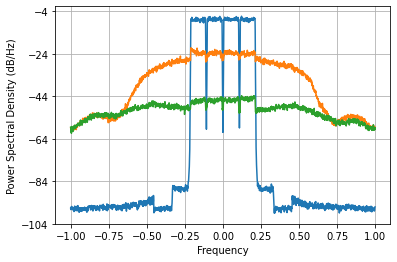

Loss =  1.1572502270120376e-05 Accuracy =  -34.41112752039984 dbs


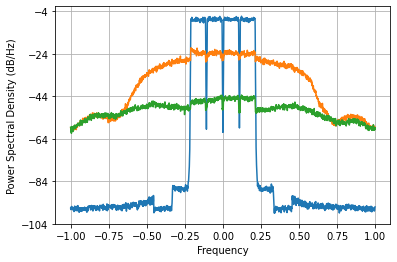

Loss =  1.187191747972084e-05 Accuracy =  -34.30019157471818 dbs


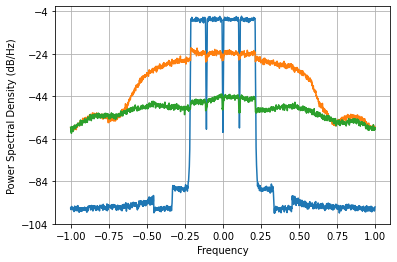

Loss =  1.2033404649855576e-05 Accuracy =  -34.24151505628531 dbs


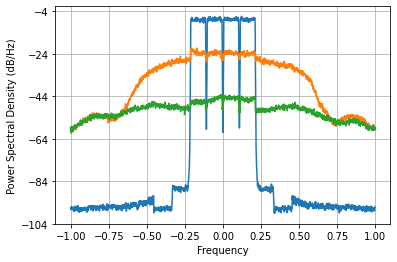

Loss =  1.1594407377239536e-05 Accuracy =  -34.40291471159001 dbs


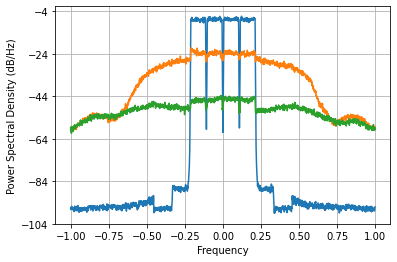

Loss =  1.1421045080080088e-05 Accuracy =  -34.46834180944295 dbs


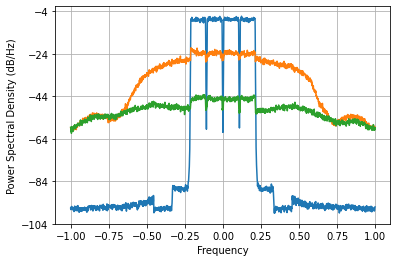

Loss =  1.2038872262399607e-05 Accuracy =  -34.23954220261089 dbs


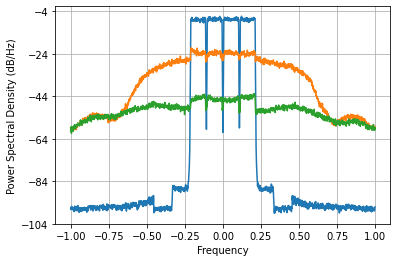

Loss =  1.2119777450420304e-05 Accuracy =  -34.210453815231325 dbs


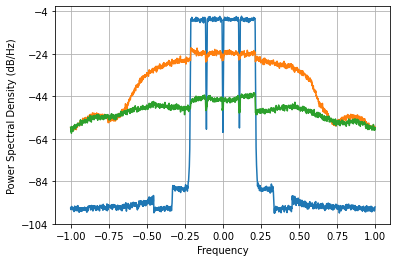

Loss =  1.2095191270475275e-05 Accuracy =  -34.21927286106487 dbs


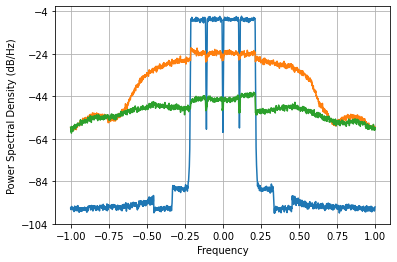

Loss =  1.2170759120079563e-05 Accuracy =  -34.19222359601974 dbs


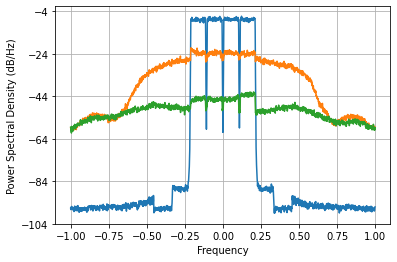

Loss =  1.2257264088221917e-05 Accuracy =  -34.16146483421408 dbs


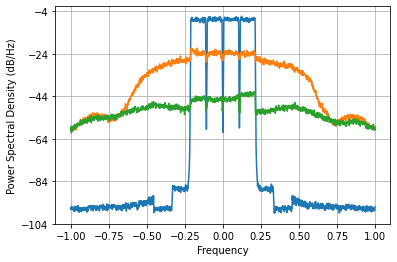

Loss =  1.2312074804694369e-05 Accuracy =  -34.142087812060005 dbs


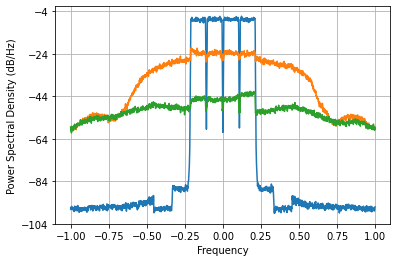

Loss =  1.2272995970293535e-05 Accuracy =  -34.15589435066106 dbs


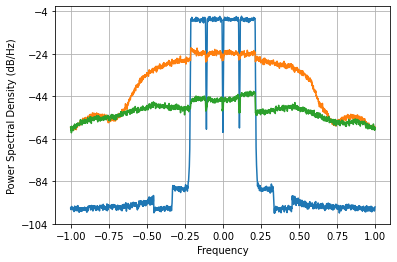

Loss =  1.2158196431456844e-05 Accuracy =  -34.19670870991628 dbs


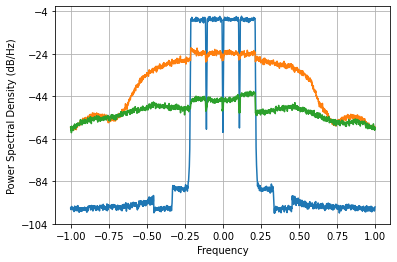

Loss =  1.2003041315141577e-05 Accuracy =  -34.252487257210326 dbs


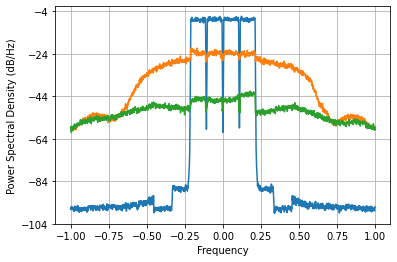

Loss =  1.1812725826182069e-05 Accuracy =  -34.32189902599295 dbs


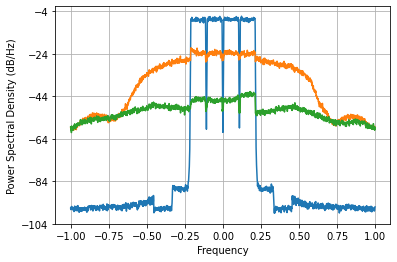

Loss =  1.1592314794505748e-05 Accuracy =  -34.40369860603611 dbs


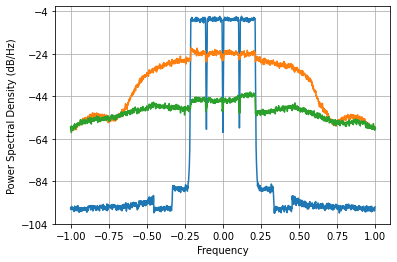

Loss =  1.1333600093773652e-05 Accuracy =  -34.50172142198837 dbs


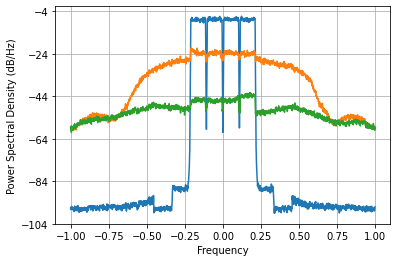

Loss =  1.1060793121991505e-05 Accuracy =  -34.60753757210095 dbs


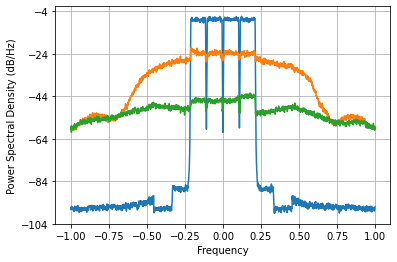

Loss =  1.079185967275496e-05 Accuracy =  -34.714437371467376 dbs


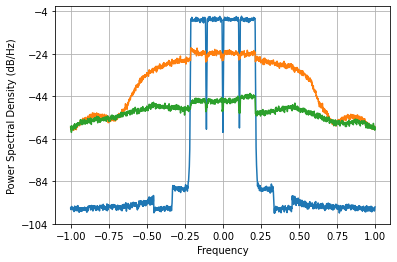

Loss =  1.0551761177920603e-05 Accuracy =  -34.81215073593159 dbs


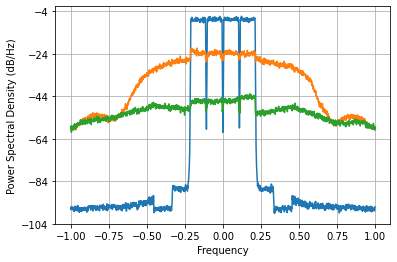

Loss =  1.034985946323887e-05 Accuracy =  -34.89605573973003 dbs


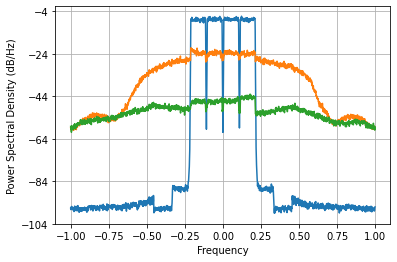

Loss =  1.0176200406830718e-05 Accuracy =  -34.96954375443283 dbs


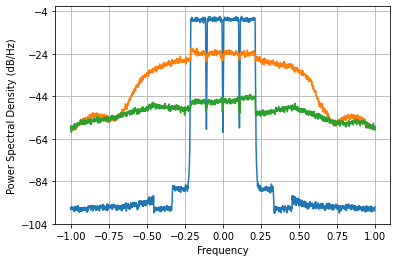

Loss =  1.0018662115319945e-05 Accuracy =  -35.03730296646808 dbs


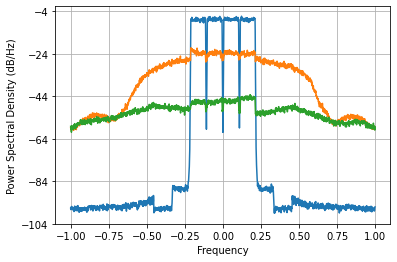

Loss =  9.871910814212703e-06 Accuracy =  -35.10138803527254 dbs


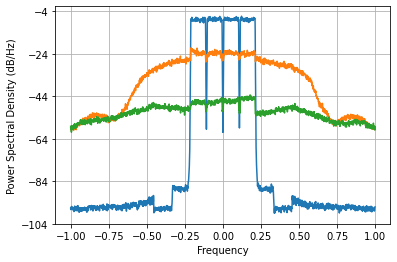

Loss =  9.736644318057807e-06 Accuracy =  -35.16130721273305 dbs


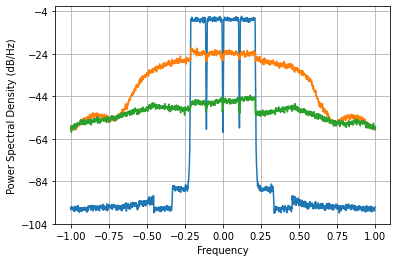

Loss =  9.608941661042136e-06 Accuracy =  -35.218644700374384 dbs


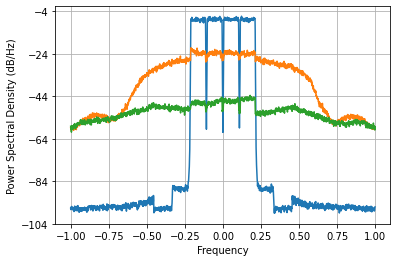

Loss =  9.479308078800887e-06 Accuracy =  -35.27763388561719 dbs


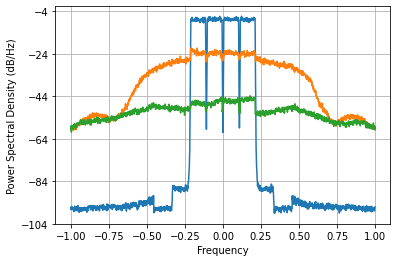

Loss =  9.330749893354517e-06 Accuracy =  -35.346234781766086 dbs


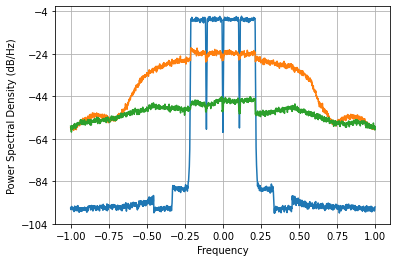

Loss =  9.14074543232146e-06 Accuracy =  -35.43558412579894 dbs


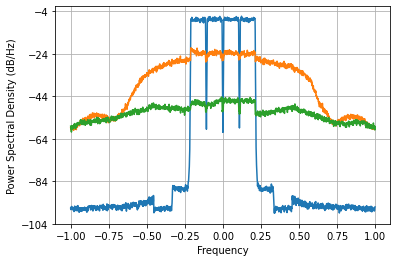

Loss =  9.058703721918436e-06 Accuracy =  -35.474739710307894 dbs


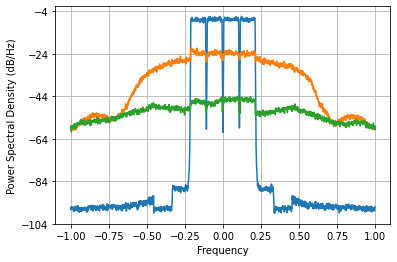

Loss =  9.526698611394827e-06 Accuracy =  -35.25597600683257 dbs


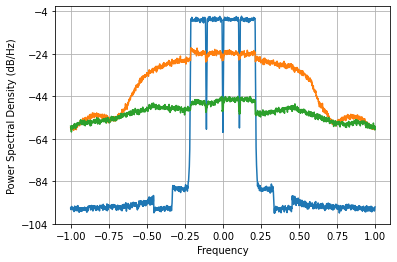

Loss =  9.522369999746758e-06 Accuracy =  -35.25794974342179 dbs


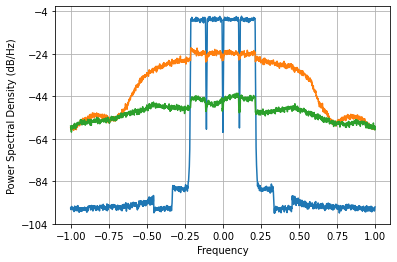

Loss =  1.0827086375614995e-05 Accuracy =  -34.70028425209395 dbs


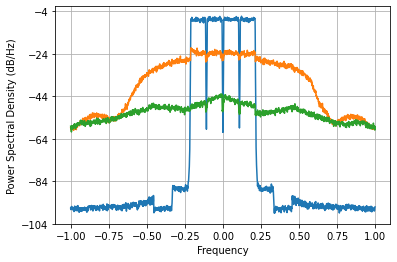

Loss =  9.355777780879947e-06 Accuracy =  -35.334601288230026 dbs


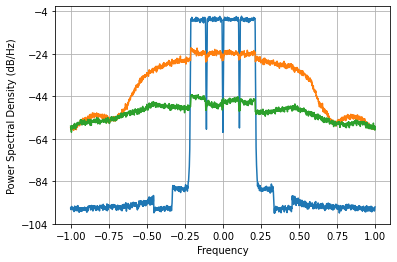

Loss =  1.0029490544617284e-05 Accuracy =  -35.03261153416647 dbs


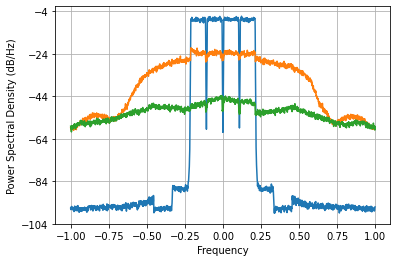

Loss =  9.255059825798135e-06 Accuracy =  -35.38160796259493 dbs


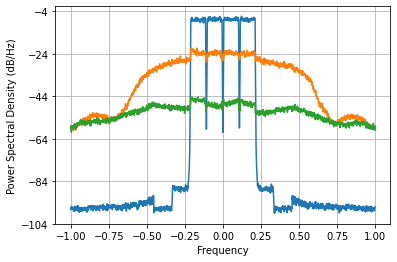

Loss =  8.917681109437969e-06 Accuracy =  -35.54288088489357 dbs


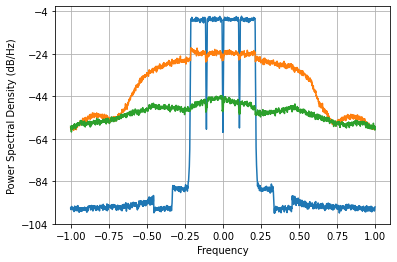

Loss =  9.033076542039906e-06 Accuracy =  -35.48704336433149 dbs


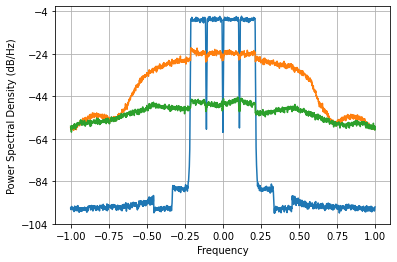

Loss =  8.733260901390418e-06 Accuracy =  -35.63363592025966 dbs


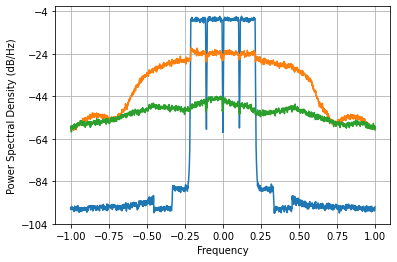

Loss =  8.57518590858885e-06 Accuracy =  -35.71296482440008 dbs


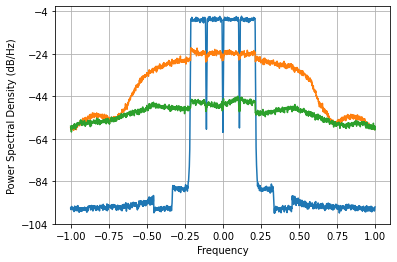

Loss =  8.874303288685715e-06 Accuracy =  -35.56405759581552 dbs


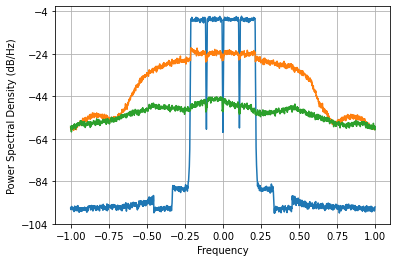

Loss =  8.386703219742172e-06 Accuracy =  -35.80948751777227 dbs


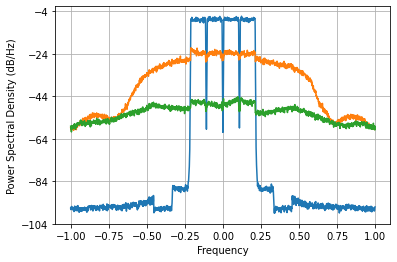

Loss =  8.735003489730759e-06 Accuracy =  -35.632769438637894 dbs


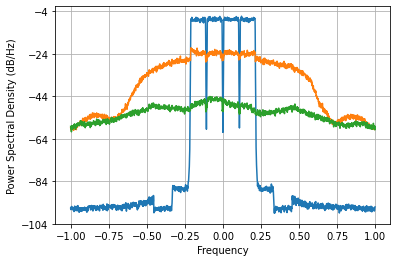

Loss =  8.41564664264259e-06 Accuracy =  -35.7945253471367 dbs


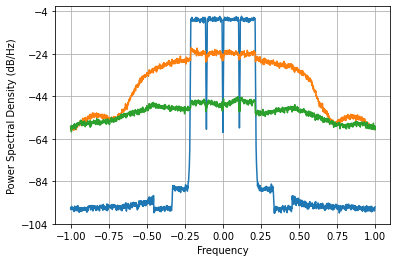

Loss =  8.775912584394e-06 Accuracy =  -35.61247738045053 dbs


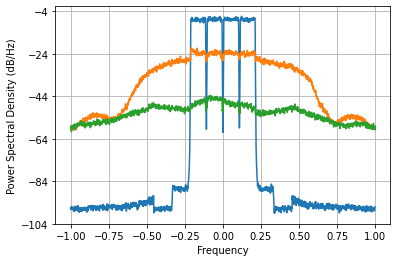

Loss =  8.711563010138817e-06 Accuracy =  -35.64443944495752 dbs


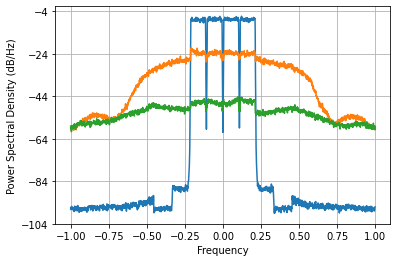

Loss =  8.804464001405384e-06 Accuracy =  -35.598371045811284 dbs


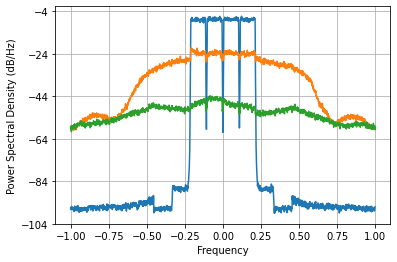

Loss =  8.506159626200786e-06 Accuracy =  -35.74806498283463 dbs


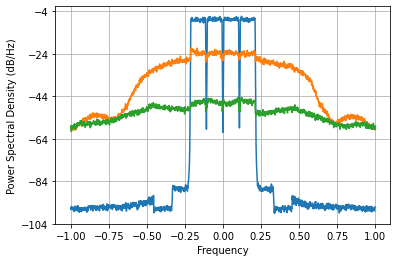

Loss =  8.756715576757937e-06 Accuracy =  -35.62198782890184 dbs



In [ ]:
net = Model(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])
# net
net=net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,100,scheduler,save_flag=False)

In [ ]:
def train_of_epoch(train_queue, model, criterion, optimizer):
  def closure():
    predicted = model(input_batch)
    loss = criterion(predicted, desired)
    optimizer.zero_grad()
    loss.backward()
    return loss
  for step, (train) in enumerate(train_queue):
      
        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cuda()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cuda()
        # optimizer.zero_grad()
        # out = model.forward(input_batch)
        # loss = criterion(out, desired)

        # loss.backward()

        optimizer.step(closure)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


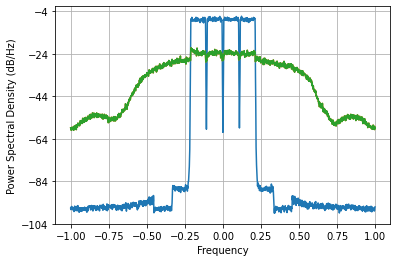

Loss =  0.0013071259600240172 Accuracy =  -13.882225866918166 dbs


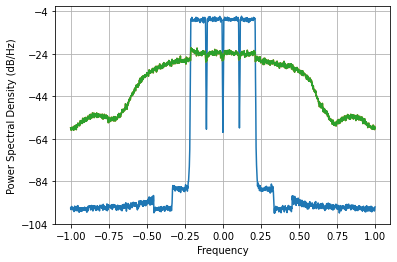

Loss =  0.0013071235058546614 Accuracy =  -13.882234020938835 dbs



In [ ]:
net = Cell()
# net
net=net.to("cuda:0")
optimizer = torch.optim.LBFGS(net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1)
train(train_queue, valid_queue, net, loss_fn, optimizer,2,scheduler,save_flag=False)

# print Model

In [ ]:
!pip3 uninstall torch
!pip3 install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Uninstalling torch-1.4.0+cu92:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.6/dist-packages/caffe2/*
    /usr/local/lib/python3.6/dist-packages/torch-1.4.0+cu92.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.4.0+cu92
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu92/torch-1.4.0%2Bcu92-cp36-cp36m-linux_x86_64.whl


In [ ]:
class Model(nn.Module):
    def __init__(self, layers, width, delay):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(layers):
            self.layers.append(layer(delay[i], width))
    def forward(self, x):
        out = x.clone()*10
        for i in range(len(self.layers)):
            out = self.layers[i](out) + x
        return out

In [ ]:
# net=layer([0,1,2,3,4],5)
net = LowModel(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])

# net=Cell()
net=net.to("cuda:0")
transforms = [

# AFIR_CMPX
  ht.Fold("(Constant > Gather) ", 'CG', 'CG'),  
  ht.Fold("(Constant > Reshape)", 'CR', 'CR'),     
  ht.Fold('CG > CR', 'CG_CR', 'CG_CR'),
  ht.Fold('Shape > CG', 'S_CG', 'S_CG'),
  ht.Fold('CG_CR > Conv', 'CG_CR_Conv', 'CG_CR_Conv'),
  ht.Fold('CG_CR_Conv > Add', 'CG_CR_Conv_Add0', 'CG_CR_Conv_Add0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Add0', 'CG_CR_Conv_Add', 'CG_CR_Conv_Add'),
  ht.Fold('CG_CR_Conv > Sub', 'CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub', 'CG_CR_Conv_Sub'),
  ht.Fold('CG_CR_Conv_Sub > Concat', 'CR1', 'CR1'),
  ht.Fold('CG_CR_Conv_Add > CR1', 'FIR', 'FIR'),
  
# Polynommial

  ht.Fold('Shape > ConstantOfShape', 'Poly', 'Abs-Poly'),  
# Prod_cmp
  ht.Fold('CG_CR > Mul', 'Mul0', 'Mul0'),  
  ht.Fold('CG_CR > Mul0', 'Mul', 'Mul'),
  ht.Fold('Mul > Sub', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Mul_s', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Add', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul > Mul_a', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul_s > Concat', 'Mul_s_c', 'Mul_s_c'),
  ht.Fold('Mul_a > Mul_s_c', 'Mul', 'Mul'),
# Delay
  ht.Fold('Constant > Unsqueeze', 'CU', 'CU'),
  ht.Fold('S_CG > Unsqueeze', 'S_CG_U', 'S_CG_U'),
  ht.Fold('CU > DynamicSlice', 'CU_DS', 'CU_DS'),
  ht.Fold('S_CG_U > CU_DS', 'B1', 'B1'),
  ht.Fold('CU > B1', 'B2', 'B2'),
  ht.Fold('Pad > B2', 'Delay', 'Delay'),
  # ht.Fold('> Pad', 'Inp', 'Inp'),
  
  # ht.Fold('CG_CR_Conv > B2', 'B3', 'B3'),
  # ht.Fold('B3 > Add', 'B4', 'B4'),
  # ht.Fold('B3 > Sub', 'B6', 'B6'),
  # ht.Fold('B3 > B6', 'B7', 'B7'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B7 > Concat', 'B8', 'B8'),
  # ht.Fold('B5 > B8', 'B9', 'B9'),
  # ht.Fold('B9 > CR', 'FIR', 'FIR'),    

  

#Sum
  ht.Fold('Poly > Add', 'Add', 'Add'),
  ht.Fold('Add > Add', 'Sum', 'Sum'),
  ht.Fold('Sum > Add', 'Sum', 'Sum'),
  ht.Fold('Add > Sum', 'Sum', 'Sum'),
  ht.Fold('Sum > Sum', 'Sum', 'Sum'),
  ht.Fold('Pad > B2', 'Delay', 'Delay'),




]
hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)


In [ ]:
transforms = [
# INPUT
  ht.Fold("(Constant > Mul) ", 'Input', 'Input'),  


# AFIR_CMPX
  ht.Fold("(Constant > Gather) ", 'CG', 'CG'),  
  ht.Fold("(Constant > Reshape)", 'CR', 'CR'),     
  ht.Fold('CG > CR', 'CG_CR', 'CG_CR'),
  ht.Fold('Shape > CG', 'S_CG', 'S_CG'),
  ht.Fold('CG_CR > Conv', 'CG_CR_Conv', 'CG_CR_Conv'),
  ht.Fold('CG_CR_Conv > Add', 'CG_CR_Conv_Add0', 'CG_CR_Conv_Add0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Add0', 'CG_CR_Conv_Add', 'CG_CR_Conv_Add'),
  ht.Fold('CG_CR_Conv > Sub', 'CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub0'),
  ht.Fold('CG_CR_Conv > CG_CR_Conv_Sub0', 'CG_CR_Conv_Sub', 'CG_CR_Conv_Sub'),
  ht.Fold('CG_CR_Conv_Sub > Concat', 'CR1', 'CR1'),
  ht.Fold('CG_CR_Conv_Add > CR1', 'FIR', 'FIR'),
  
# Polynommial

  ht.Fold('Shape > ConstantOfShape', 'Poly', 'Abs-Poly'),  
# Prod_cmp
  ht.Fold('CG_CR > Mul', 'Mul0', 'Mul0'),  
  ht.Fold('CG_CR > Mul0', 'Mul', 'Mul'),
  ht.Fold('Mul > Sub', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Mul_s', 'Mul_s', 'Mul_s'),
  ht.Fold('Mul > Add', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul > Mul_a', 'Mul_a', 'Mul_a'),
  ht.Fold('Mul_s > Concat', 'Mul_s_c', 'Mul_s_c'),
  ht.Fold('Mul_a > Mul_s_c', 'Mul', 'Mul'),
# Delay
  ht.Fold('Constant > Unsqueeze', 'CU', 'CU'),
  ht.Fold('S_CG > Unsqueeze', 'S_CG_U', 'S_CG_U'),
  ht.Fold('CU > DynamicSlice', 'CU_DS', 'CU_DS'),
  ht.Fold('S_CG_U > CU_DS', 'B1', 'B1'),
  ht.Fold('CU > B1', 'B2', 'B2'),
  ht.Fold('Pad > B2', 'Delay', 'Delay'),
  # ht.Fold('> Pad', 'Inp', 'Inp'),
  
  # ht.Fold('CG_CR_Conv > B2', 'B3', 'B3'),
  # ht.Fold('B3 > Add', 'B4', 'B4'),
  # ht.Fold('B3 > Sub', 'B6', 'B6'),
  # ht.Fold('B3 > B6', 'B7', 'B7'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B3 > B4', 'B5', 'B5'),
  # ht.Fold('B7 > Concat', 'B8', 'B8'),
  # ht.Fold('B5 > B8', 'B9', 'B9'),
  # ht.Fold('B9 > CR', 'FIR', 'FIR'),    

  

#Sum
  ht.Fold('Poly > Add', 'Add', 'Add'),
  ht.Fold('Add > Add', 'Sum', 'Sum'),
  ht.Fold('Sum > Add', 'Sum', 'Sum'),
  ht.Fold('Add > Sum', 'Sum', 'Sum'),
  ht.Fold('Sum > Sum', 'Sum', 'Sum'),
  ht.Fold('Input > Pad', 'Input', 'Input'),
  ht.Fold('B2', 'B2', 'Delay'),
  




]

In [ ]:
class ModelDraw(nn.Module):
  def __init__(self):
    super(ModelDraw, self).__init__()
    self.model = Model(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])

  def forward(self, x):
    x = x * 10        
    out = self.model(x)    
    return out

In [ ]:
net = Model(3,5,[[0,1,2,3,4],[5,6,7,8,9],[4,3,2,1,10]])
net.to("cuda:0")
hl.build_graph(net, Variable(torch.zeros([1,2,100]).double().cuda()),transforms=transforms)

/content/drive/My Drive/Colab Notebooks/huawei/blocks/blocks.py:37: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self.op(x)[:,:,:x.shape[2]]
